# Определение возраста покупателей

Построение модели (нейронной сети) для определения возраста покупателей

## Исследовательский анализ данных

Выполним все необходимые импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 12345
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Выполним загрузку данных:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Выведем общую инфрмацию о датасете

In [3]:
display(labels.sample(10, random_state = RANDOM_STATE))
print('размер выборки: ', labels.shape)
print('Общая информация о выборке:')
print(labels.info())

,file_name,real_age
5370,005370.jpg,50
4516,004516.jpg,41
3968,003968.jpg,46
2188,002188.jpg,85
5833,005833.jpg,14
5521,005521.jpg,40
5393,005393.jpg,14
3913,003913.jpg,53
934,000934.jpg,4
6260,006264.jpg,32


размер выборки:  (7591, 2)
Общая информация о выборке:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


В выборке найдено 7591 изображения с указанием возраста. Рассмотрим, как распределены возрасты в выборке:

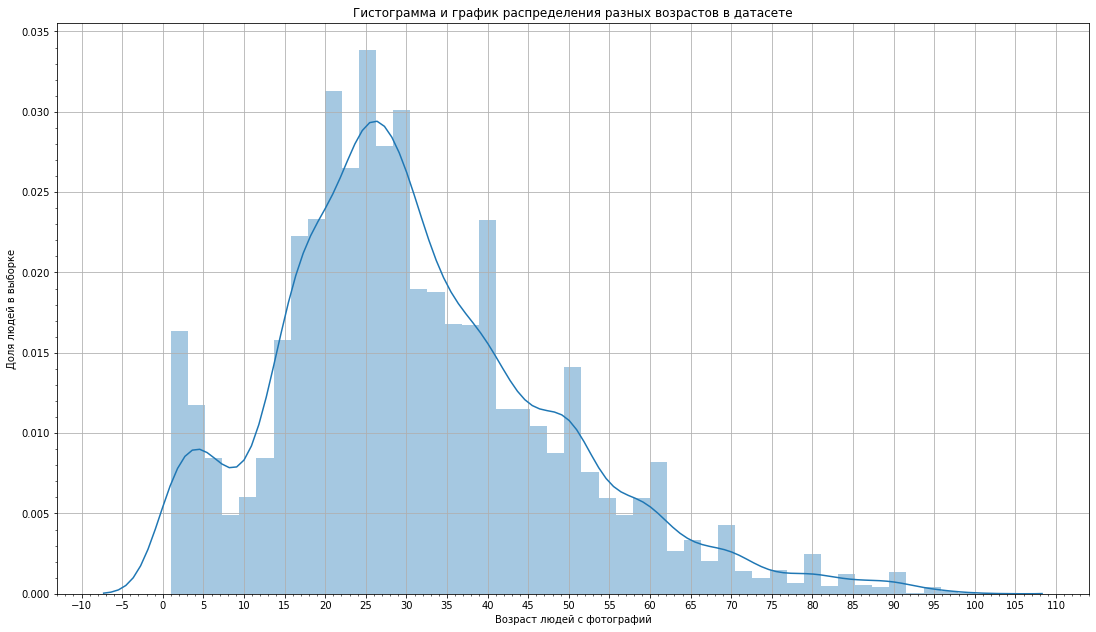

In [4]:
fig,ax = plt.subplots()
sns_plot = sns.distplot(labels['real_age'])
fig = sns_plot.get_figure()
fig.set_size_inches(18.5, 10.5)
ax.grid()
ax.set_title('Гистограмма и график распределения разных возрастов в датасете')
ax.set_xlabel('Возраст людей с фотографий')
ax.set_ylabel('Доля людей в выборке')
ax.xaxis.set_major_locator(MultipleLocator(5))

plt.minorticks_on()
plt.show()

<b>Вывод:</b><br>
 Как можно видеть, в датасете преобладают фотографии людей 20-30 лет, также довольно много фотографий детей до 5 лет (вероятно, чтобы можно было отличить ребенка от куклы или домашнего животного, например - это очень влияет на определение целевой аудитории), количество фотографий подростков минимально для 10-леток, но плавно растет до 18 лет.Возможно, этого может быть достаточно для правильной идентификации тех, кому меньше и больше 18 (после - количество фотографий заметно возрастает), однако кажется маловероятным. Безусловно, для людей "около" этого возраста при необходимости нужно спрашивать документы, особенно в условиях развития косметологии макияжа (в 30 можно выглядеть на 18, и в 16  на 30), но тем не менее, это очень сильно зависит от того, какую цель мы ставим перед моделью: найти того, у которого стоит спросить паспорт или постараться отделить тех, кому меньше и больше 18. К слову - первая задача более реалистична (опять же с учетом всех возможностей макияжа и косметологии) и текущий датасет покрывает ее потребности. <br> Также наблюдаются явные пики каждое "десятилетие" - 40,50,60,70,80,90. Возможно, то связано с тем, что датасет размечался людьми, а людям гораздо "виднее" и важнее десятилетие, чем конкретный возраст.  Для определения целевой возрастной аудитории, к которой относится покупатель, это, наверное, самое важное. Между 41 и 42 годами разница незначительна, здесь ошибка идентификации не так важна, а вот между 40 и 50 - уже заметнее. Ну и конечно, количество фотографий имеет тенденцию к плавному уменьшению после 30-летнего рубежа - после этого возраста и выживет все меньше каждое десятилетие, и интересы все более сходятся.

Рассмотрим несколько фотографий из датасета

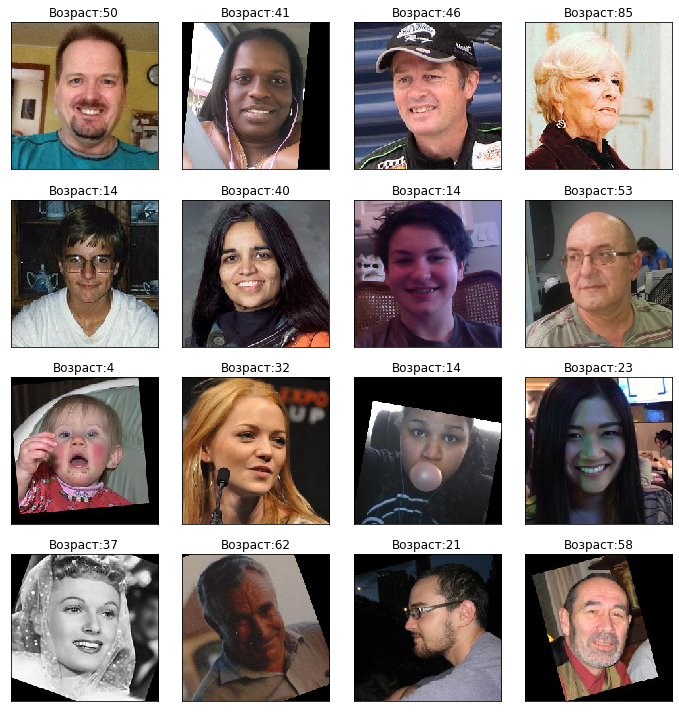

In [5]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Возраст:'+str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<b>Вывод:</b><br>
Как можно видеть, в датасете содержатся совершенно разные фотографии людей разных возрастов: есть фотографии более и менее качественные, есть черно-белые, есть повернутые и немного обрезанные. Вероятнее всего, придется применять аугментации для построения более качественной модели (есть смысл применить вращения).

## Обучение модели

Код модели:

```python

# < код >

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import pandas as pd



def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1./255,
                          horizontal_flip=True,
                          rotation_range = 15
                          )

    train_datagen_flow = (train_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(224, 224), 
                          batch_size=8, 
                          class_mode='raw',
                          subset='training', 
                          seed=12345
                          )
    )
    return train_datagen_flow


def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1/255.
                          )

   
    test_datagen_flow = (test_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(224, 224), 
                          batch_size=8, 
                          class_mode='raw',
                          subset='validation', 
                          seed=12345
                          )
    )
    
    return test_datagen_flow  

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr = 0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, epochs=14, batch_size=None,
               steps_per_epoch=None, validation_steps=None):
  
    train_datagen_flow = train_data
    test_datagen_flow = test_data


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=(test_data), epochs=epochs,
              steps_per_epoch=steps_per_epoch, batch_size=batch_size,
              validation_steps=validation_steps, 
              verbose=2, shuffle=True)
    return model 

```

```

# < результат вывода на экран >

Train for 712 steps, validate for 238 steps
Epoch 1/14
2021-08-30 05:04:31.310815: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-08-30 05:04:34.950215: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
712/712 - 179s - loss: 198.6730 - mae: 10.5809 - val_loss: 199.7021 - val_mae: 10.5710
Epoch 2/14
712/712 - 89s - loss: 109.2764 - mae: 7.9822 - val_loss: 116.6561 - val_mae: 8.0948
Epoch 3/14
712/712 - 89s - loss: 83.8744 - mae: 6.9966 - val_loss: 183.5130 - val_mae: 10.3455
Epoch 4/14
712/712 - 89s - loss: 67.4521 - mae: 6.2888 - val_loss: 108.0676 - val_mae: 8.0502
Epoch 5/14
712/712 - 89s - loss: 52.5585 - mae: 5.5446 - val_loss: 151.3839 - val_mae: 9.0686
Epoch 6/14
712/712 - 90s - loss: 47.4059 - mae: 5.2930 - val_loss: 80.4841 - val_mae: 6.6483
Epoch 7/14
712/712 - 90s - loss: 38.9672 - mae: 4.8385 - val_loss: 119.5068 - val_mae: 7.9588
Epoch 8/14
712/712 - 90s - loss: 33.4412 - mae: 4.4457 - val_loss: 74.2805 - val_mae: 6.3549
Epoch 9/14
712/712 - 90s - loss: 31.3898 - mae: 4.3083 - val_loss: 89.1969 - val_mae: 6.9847
Epoch 10/14
712/712 - 90s - loss: 31.9788 - mae: 4.3346 - val_loss: 90.7588 - val_mae: 7.1731
Epoch 11/14
712/712 - 89s - loss: 27.4538 - mae: 4.0062 - val_loss: 79.5610 - val_mae: 6.4612
Epoch 12/14
712/712 - 90s - loss: 24.3230 - mae: 3.7968 - val_loss: 66.2226 - val_mae: 6.0435
Epoch 13/14
712/712 - 90s - loss: 20.4775 - mae: 3.5062 - val_loss: 73.6770 - val_mae: 6.2183
Epoch 14/14
712/712 - 90s - loss: 21.7189 - mae: 3.5588 - val_loss: 75.9621 - val_mae: 6.3621
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 9s - loss: 75.9621 - mae: 6.3621
Test MAE: 6.3621



```

## Анализ обученной модели

Можно видеть, что в целом модель ошибается на 6,36 года, что в целом может покрыть поставленные цели:
1. В случае, если перед Вами человек старше 40 лет - такая ошибка обычно не критрична, после этого возраста интересы и потребности постепенно сходятся к определенным, и погрешность чуть более 5 лет вполне возможна. тем более, что система, по логике вещей, должна анализировать не только того, кто непосредственно производит покупку, но и споровождающих (есть ли дети среди них, или более молодые, или более пожилые), а также историю покупок, и в таком случае выдавать рекомендации.
2. В случае, когда человек от 20 до 40 лет, интересы и приоритеты могут быть очень разными, и здесь необходим более глубокий анализ, нежели только возраст покупателя: история покупок, сопровождающие лица (дети, сверстники, предполагаемые родители), даже просто список продуктов в корзине (насколько верно будет предлагатьо купить мясо тому, у кого в корзине одни овощи (если это первая покупка)): все, что может оказать влияние на спрос конкретного покупателя
3. В случае, когда необходимо определить, можно ли продавать потенциальному покупателю подакцызные товары, здесь может сработать только одно: рекомендация, стоит ли спросить паспорт. Довольно часто 25-26 - летний человек выглядит старше, хотя здесь можно было бы расширить диапазон намеренно: то есть рекомендовать спрашивать паспорт не только у тех, кто попал в диапазон 18+- MAE, а хотя бы (16 - 23) +- MAE. Это обеспечит более точное покрытие (опять же в связи с развитием косметологии и техник макияжа) и более качественное решение вопроса
<br>
<br>
 Можно видеть, что модель довольно сильно переобучается. MAE на тестовой почти в 2 раза больше, чем на обучающей. В принципе, это свойственно нейронным сетям с большим количеством слоев (а 50 - это довольно много). Причем можно видеть, что чем больше эпох и чем лучше результат на обучающей выборке, тем сильнее переобучается модель.  Здесь также можно заметить, что минимальное значение MAE на тестовой выборке было на эпохе 12 - 6.04, после нее MAE на тестовой начало снова расти - переобучение усилиллось. Здесь важно правильно выбрать точку остановки обучения модели: когда качество модели на тестовой выборке перестает улучшаться и находитися возле одного значения. Полагаю, для данной модели столько эпох достаточно.
